In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


from surprise import Dataset, NormalPredictor, Reader
from surprise.model_selection import cross_validate, KFold, train_test_split
from surprise.prediction_algorithms import knns , matrix_factorization



import warnings
warnings.filterwarnings("ignore")  # Ignore all warnings


In [2]:
links = pd.read_csv('Synthetic_Movie_Lens/links.csv') 
movies = pd.read_csv('Synthetic_Movie_Lens/movies.csv')  
ratings = pd.read_csv('Synthetic_Movie_Lens/ratings.csv')  
tags = pd.read_csv('Synthetic_Movie_Lens/tags.csv')  

## Question 1 - Explore the dataset

In [3]:
# links.head()

In [4]:
# movies.head()

In [5]:
ratings.head()

,Unnamed: 0,userId,movieId,rating,timestamp
0,0,496,112852,3.0,1415520462
1,1,391,1947,4.0,1030945141
2,2,387,1562,1.5,1095041022
3,3,474,2716,4.5,1053020930
4,4,483,88125,4.5,1311337237


In [6]:
# tags.head()

### Compute the sparsity of the movie rating dataset:

In [7]:
# Create the rating matrix
rating_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating')

# Compute the sparsity of the rating matrix
num_ratings = rating_matrix.count().sum()  # Total number of non-missing ratings
num_possible_ratings = rating_matrix.shape[0] * rating_matrix.shape[1]  # Total number of possible ratings
sparsity = num_ratings / num_possible_ratings  # Sparsity calculation

print("Sparsity of the rating matrix:", sparsity)

Sparsity of the rating matrix: 0.016999683055613623


### Plot a histogram showing the frequency of the rating values:

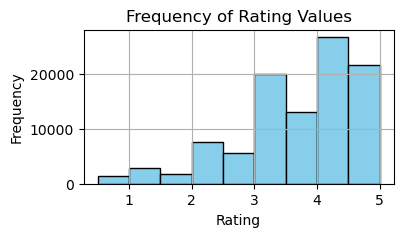

In [8]:
# Plot histogram of rating values
plt.figure(figsize=(4, 2))
plt.hist(ratings['rating'], bins=9, color='skyblue', edgecolor='black')
plt.title('Frequency of Rating Values')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


The distribution of ratings indicates a skew towards higher scores, suggesting that individuals who disliked the movie may not be as inclined to express their dissatisfaction as those who enjoyed it. Otherwise, the distribution would likely resemble a normal curve without skew.

### Plot the distribution of the number of ratings received among movies:

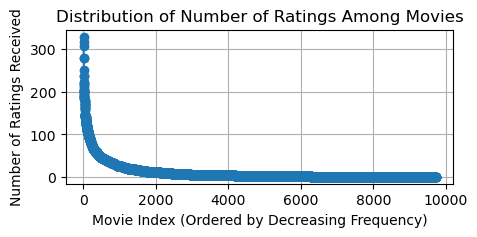

In [9]:
import matplotlib.pyplot as plt

# Count the number of ratings received by each movie
movie_ratings_count = ratings['movieId'].value_counts()

# Sort movies based on the frequency of ratings
sorted_movie_indices = movie_ratings_count.index
sorted_ratings_count = movie_ratings_count.values

# Plot the distribution
plt.figure(figsize=(5, 2))
plt.plot(range(1, len(sorted_movie_indices) + 1), sorted_ratings_count, marker='o', linestyle='-')
plt.title('Distribution of Number of Ratings Among Movies')
plt.xlabel('Movie Index (Ordered by Decreasing Frequency)')
plt.ylabel('Number of Ratings Received')
plt.grid(True)
plt.show()


### Plot the distribution of ratings among users: 

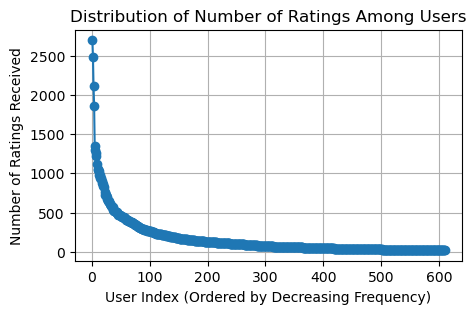

In [56]:
import matplotlib.pyplot as plt

# Count the number of ratings given by each user
user_ratings_count = ratings['userId'].value_counts()

# Sort movies based on the frequency of ratings
sorted_user_indices = user_ratings_count.index
sorted_ratings_count = user_ratings_count.values

# Plot the distribution
plt.figure(figsize=(5, 3))
plt.plot(range(1, len(sorted_user_indices) + 1), sorted_ratings_count, marker='o', linestyle='-')
plt.title('Distribution of Number of Ratings Among Users')
plt.xlabel('User Index (Ordered by Decreasing Frequency)')
plt.ylabel('Number of Ratings Received')
plt.grid(True)
plt.show()


### Discuss the salient features of the distributions

As seen, the distribution typically exhibits a abrupt decreasing trend, indicating that the frequency of ratings decreases abruptly. Less than 200 movies have been rated more than 100 times while majority of the movies have received less than 50 ratings. Recommender systems should balance this with providing recommendations for less-popular movies to avoid over-reliance on already popular items.

Similar to the distribution of ratings among movies, the distribution of ratings among users also exhibits a skewed pattern, where a small fraction of users contribute a significant portion of the ratings. In other words, less than 50 users have provided more than 500 ratings while majority of users have rated in less than 200 movies. Recommender systems should account for the varying levels of activity and engagement among users. They should prioritize recommendations based on the preferences and behavior of active users while also considering the needs of less active users to provide a balanced user experience.

### Compute the variance of the rating values received by each movie:

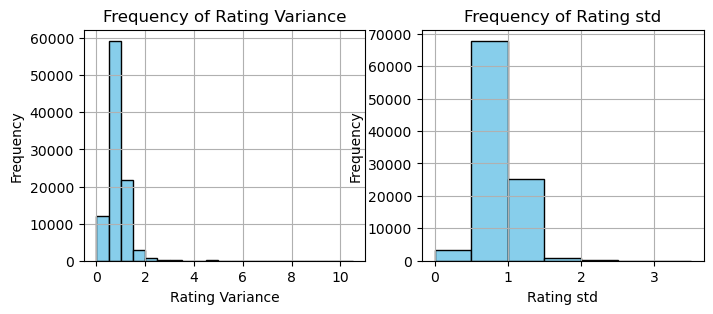

In [11]:
df1 = ratings.groupby('movieId')['rating'].transform('var')

bin_edges = [i * 0.5 for i in range(int(df1.max() / 0.5) + 2)]

# Plot histogram of rating variance
plt.figure(figsize=(8, 3))
plt.subplot(1,2,1)
# plt.figure(figsize=(4, 3))
plt.hist(df1,  bins=bin_edges, color='skyblue', edgecolor='black')
plt.title('Frequency of Rating Variance')
plt.xlabel('Rating Variance')
plt.ylabel('Frequency')
plt.grid(True)

df2 = ratings.groupby('movieId')['rating'].transform('std')

bin_edges = [i * 0.5 for i in range(int(df2.max() / 0.5) + 2)]

# Plot histogram of rating variance
plt.subplot(1,2,2)
# plt.figure(figsize=(4, 3))
plt.hist(df2,  bins=bin_edges, color='skyblue', edgecolor='black')
plt.title('Frequency of Rating std')
plt.xlabel('Rating std')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


It is shown in the above plot that the histogram is skewed towards lower variance values, which suggests that most movies have relatively consistent ratings. Specifically, most movies have ratings less than 1.5 standard deviation.

## Neighborhood-based collaborative filtering
### User-based neighborhood models

### Question 2: 

- Understanding the Pearson Correlation Coefficient:
    - Write down the formula for μu in terms of Iu and ruk;

$$
\mu_u = \frac{1}{|I_u|} \sum_{k \in I_u} r_{uk}
$$

    - In plain words, explain the meaning of Iu ∩ Iv. Can Iu ∩ Iv = ∅? (Hint: Rating matrix R is sparse)
    
It means set of movies that both users u and v have rated. Yes, it can be null set as there can be some pair of persons who have not rated a single common movie.

### QUESTION 3: 
- Understanding the Prediction function: 

We are predicting the person u's rating for movie j by adding the person u's average rating ($\mu_u$) to the weighted average of rating (relative to their average) of some (k) closest neighbors, and the mean-centering of the neighbors rating aims to consider their own relative rating. This is because of the fact that different people have different reference for the neutral opinion. Some tends to be more lineant while others tend to be more harsh when it comes to express their feeling.


### QUESTION 4: 
Design a k-NN collaborative filter

In [12]:
reader = Reader(rating_scale=(0.5, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(ratings[['userId',  'movieId',  'rating']], reader)


In [13]:
sim_options = {"name": "pearson_baseline",  "user_based": True, "shrinkage": 10}
    
def find_best_k_knn(data, title):
    result = {'k':[], 'RMSE': [], 'MAE': []}
    result['k'] = list(range(2,102,2))
    for k in range(2, 102, 2):
        algo = knns.KNNWithMeans(k=k, min_k=1, sim_options=sim_options, verbose=False)

        # Run 10-fold cross-validation and print results
        cv_res = cross_validate(algo, data, measures=["RMSE", "MAE"], cv=10, verbose=False)

        result['RMSE'].append(cv_res['test_rmse'].mean())
        result['MAE'].append(cv_res['test_mae'].mean())    

    plt.figure(figsize=(8, 3))
    plt.subplot(1,2,1)
    plt.plot(result['k'], result['RMSE'], marker='o', linestyle='-')

    plt.suptitle(title)
    plt.title('Average RMSE')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Cross-validated (10-fold) Error')
    plt.grid(True)

    plt.subplot(1,2,2)

    plt.plot(result['k'], result['MAE'], marker='*', linestyle='-')

    plt.title('Average MAE')
    plt.xlabel('Number of Neighbors (k)')
    # plt.ylabel('Cross-validated (10-fold) Error')
    plt.grid(True)
    plt.tight_layout(pad=0.5)  # Increase the space between subplots and suptitle
    plt.suptitle(title, y=1.05)  # Adjust the vertical position of the main title
    
    plt.show()

    print('Min average RMSE:', min(result['RMSE']))
    print('Number of latent factors corresponding to the Min average RMSE:', result['k'][np.argmin(result['RMSE'])])
    print('Min average MAE:', min(result['MAE']))
    print('Number of latent factors corresponding to the Min average MAE:', result['k'][np.argmin(result['MAE'])])



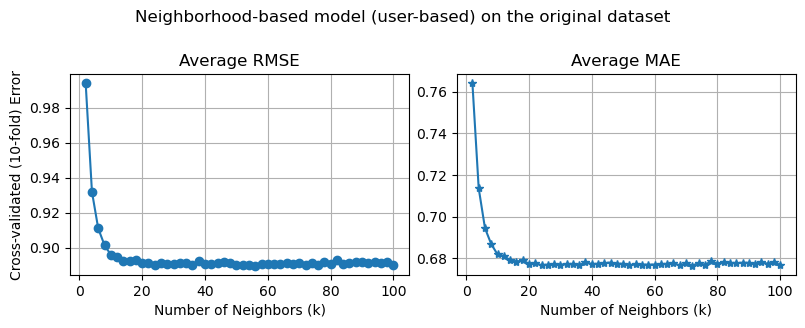

Min average RMSE: 0.8898280237612424
Number of latent factors corresponding to the Min average RMSE: 56
Min average MAE: 0.676569038216646
Number of latent factors corresponding to the Min average MAE: 72


In [14]:
find_best_k_knn(data, 'Neighborhood-based model (user-based) on the original dataset')


### QUESTION 5: 

- Use the plot from question 4, to find a ’minimum k’. 

As shown in the above plots, the minimum k can be any number between 26 and 22. Above these numbers there is no significant gain in the error. I would say minimum k is 20.

steady RMSE = range of 0.88 - 0.9
steady MAE = range of 0.675 - 0.68

## Filter model performance based on subsets of the raw data
### QUESTION 6:

In [15]:
# trimming function that takes as input the set of data and outputs a trimmed set
df = ratings
df['count'] = df.groupby('movieId')['rating'].transform('count')
df['var'] = df.groupby('movieId')['rating'].transform('var')

pop_df = df[df['count']>2]

# # unpopular movies
unpop_df = df[df['count']<=2]

# # high variance movies
hv_df = df[(df['count']>=5) & (df['var']>=2)]


#### Popular movies subset

In [16]:
pop_data = Dataset.load_from_df(pop_df[['userId',  'movieId',  'rating']], reader)

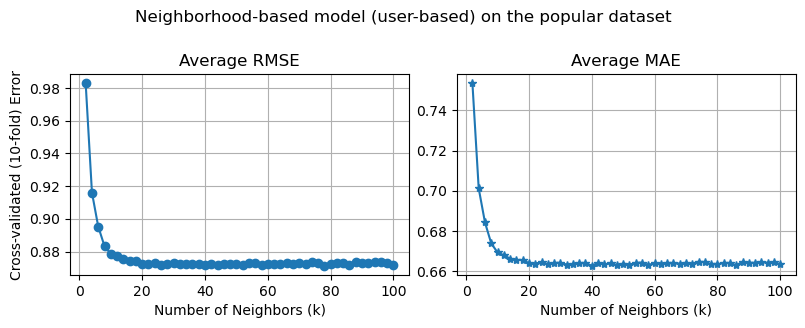

Min average RMSE: 0.8714318897854916
Number of latent factors corresponding to the Min average RMSE: 78
Min average MAE: 0.6628618167057578
Number of latent factors corresponding to the Min average MAE: 40


In [17]:
find_best_k_knn(pop_data, 'Neighborhood-based model (user-based) on the popular dataset')


#### Unpopular movies subset

In [18]:
unpop_data = Dataset.load_from_df(unpop_df[['userId',  'movieId',  'rating']], reader)

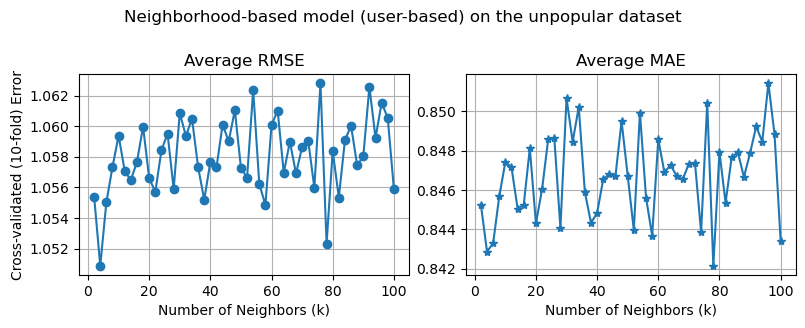

Min average RMSE: 1.0508894437986143
Number of latent factors corresponding to the Min average RMSE: 4
Min average MAE: 0.8421654486841186
Number of latent factors corresponding to the Min average MAE: 78


In [19]:
find_best_k_knn(unpop_data, 'Neighborhood-based model (user-based) on the unpopular dataset')


### High variance subset

In [20]:
hv_data = Dataset.load_from_df(hv_df[['userId',  'movieId',  'rating']], reader)

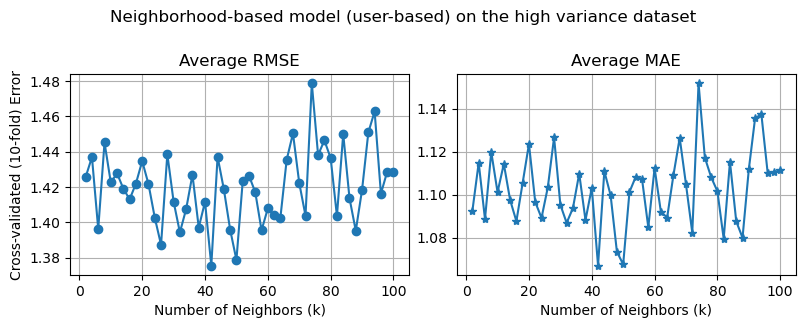

Min average RMSE: 1.375523446331703
Number of latent factors corresponding to the Min average RMSE: 42
Min average MAE: 1.0670717252239652
Number of latent factors corresponding to the Min average MAE: 42


In [21]:
find_best_k_knn(hv_data, 'Neighborhood-based model (user-based) on the high variance dataset')


Minimum average RMSE:
Popular: 0.88,
unpopular: 1.05,
high variance: 1.36

### ROC curve for all data

In [22]:
def plot_roc(ax, fpr, tpr, roc_auc, threshold):
    ax.plot(fpr, tpr, lw=2, label='Threshold = %0.1f, AUC = %0.4f' % (threshold, roc_auc))

    ax.grid(color='0.7', linestyle='--', linewidth=1)
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=15)
    ax.set_ylabel('True Positive Rate', fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(15)



In [58]:
def factorize_plot_ROC(data, algo, title):
    trainset, testset = train_test_split(data, test_size=0.1)

    # Train and test algorithm
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Get true ratings 
    true_ratings = np.array([pred.r_ui for pred in predictions])

    thresholds = [2.5, 3, 3.5, 4]
    fig, axes = plt.subplots(1, len(thresholds), figsize=(18, 4))
    fig.suptitle(title, fontsize=16)

    for i, t in enumerate(thresholds):
        y_test, y_pred = [], []
        true_labels = (true_ratings >= t).astype(int)

        fpr, tpr, _ = roc_curve(true_labels, [pred.est for pred in predictions])
        roc_auc = auc(fpr, tpr)
        plot_roc(axes[i], fpr, tpr, roc_auc, t)

    plt.tight_layout()
    plt.show()

Computing the msd similarity matrix...
Done computing similarity matrix.


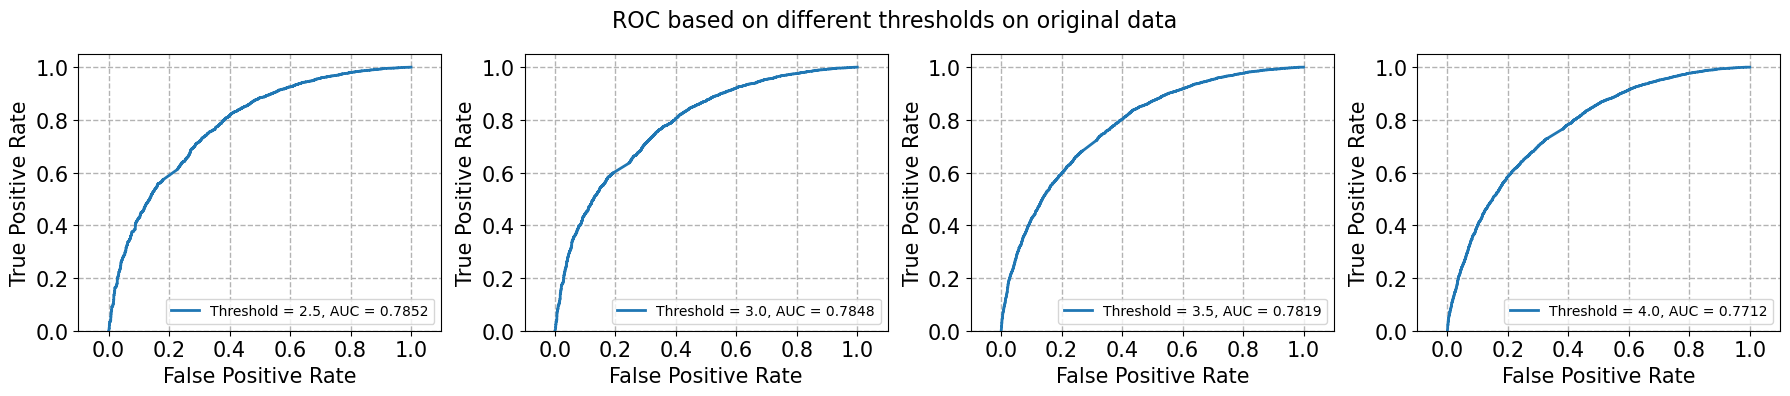

In [59]:
algo = knns.KNNWithMeans(k=20, min_k=1)
factorize_plot_ROC(data, algo, 'ROC based on different thresholds on original data')

### ROC curve for Popular subset

Computing the msd similarity matrix...
Done computing similarity matrix.


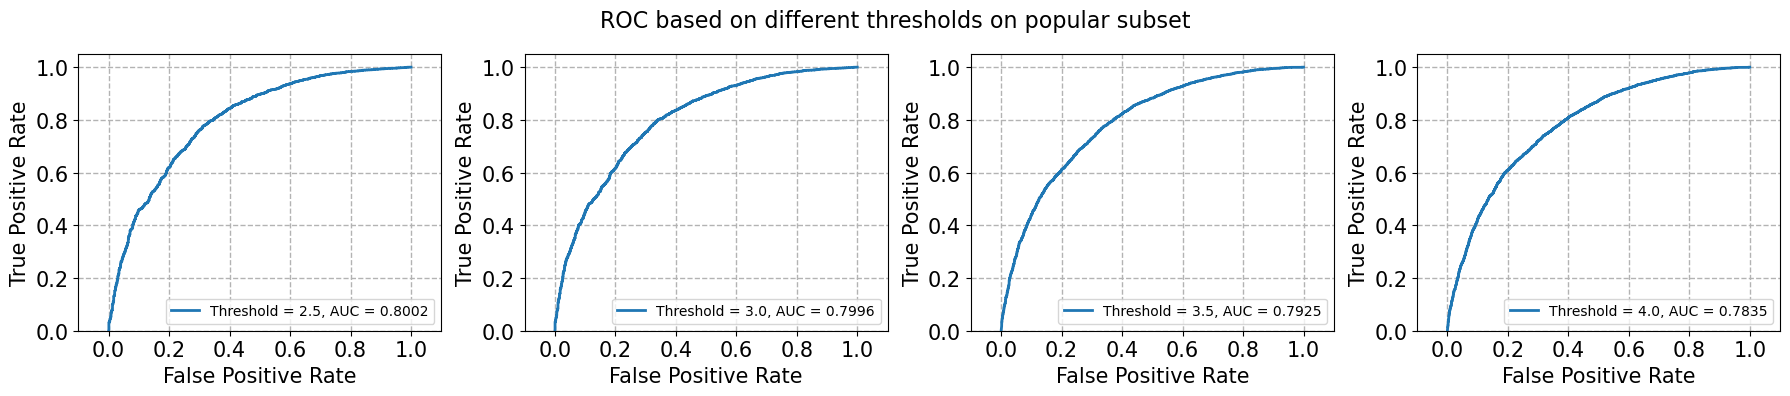

In [60]:
algo = knns.KNNWithMeans(k=20, min_k=1)
factorize_plot_ROC(pop_data, algo, 'ROC based on different thresholds on popular subset')

### ROC curve for Unpopular subset

Computing the msd similarity matrix...
Done computing similarity matrix.


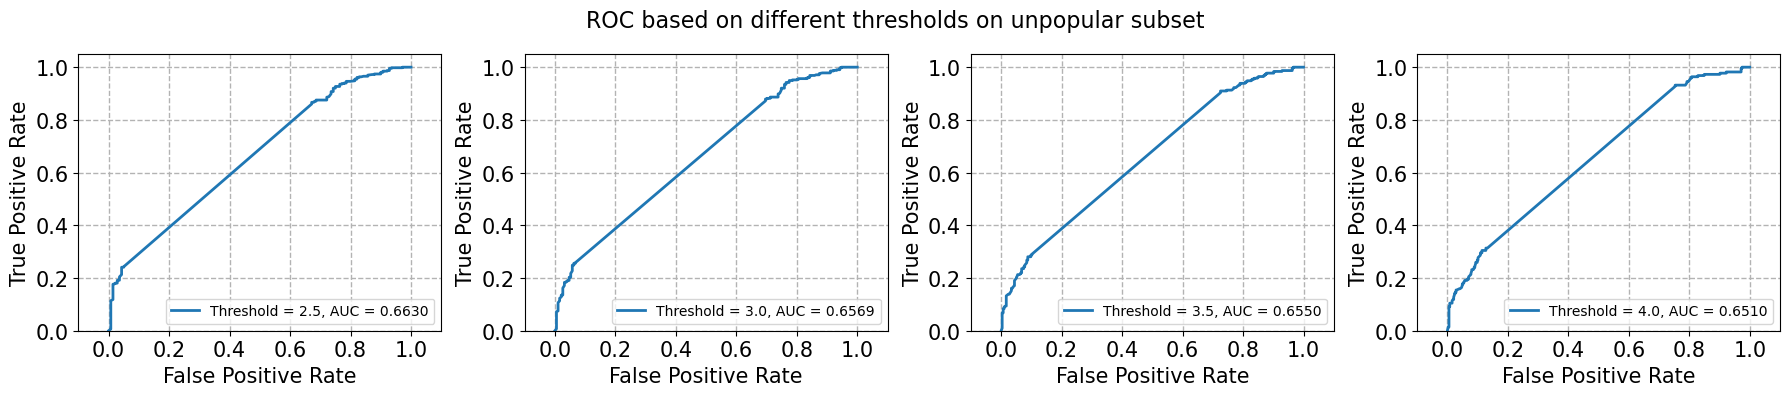

In [61]:
algo = knns.KNNWithMeans(k=20, min_k=1)
factorize_plot_ROC(unpop_data, algo, 'ROC based on different thresholds on unpopular subset')

### ROC curve for High variance subset

Computing the msd similarity matrix...
Done computing similarity matrix.


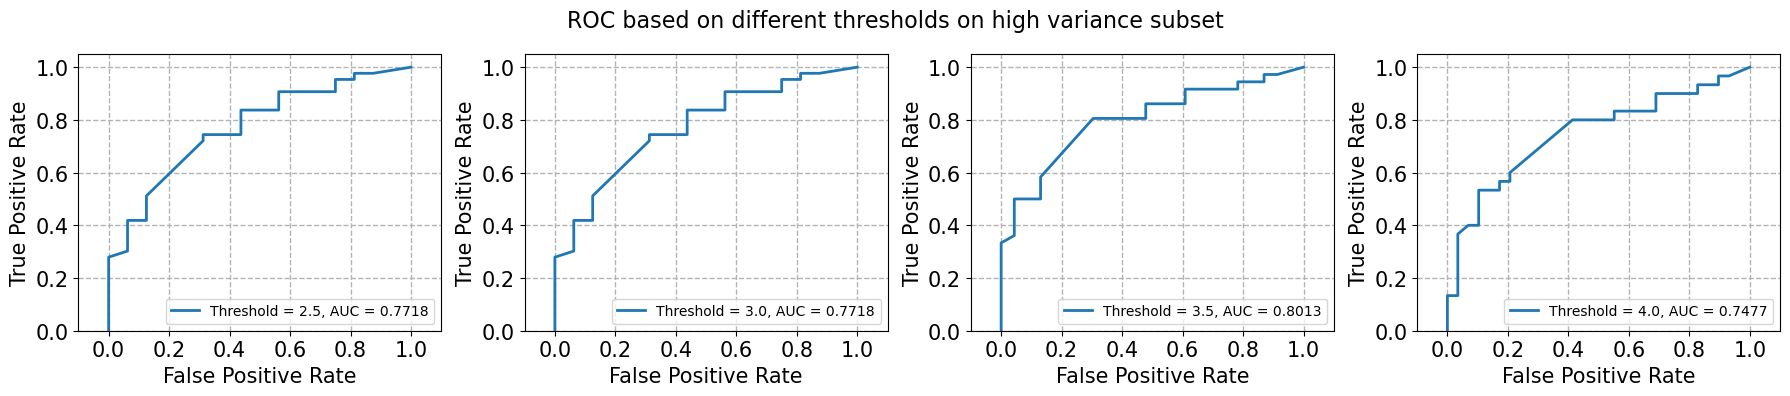

In [62]:
algo = knns.KNNWithMeans(k=42, min_k=1)
factorize_plot_ROC(hv_data, algo, 'ROC based on different thresholds on high variance subset')

## Model-based collaborative filtering

### QUESTION 7: 
- Understanding the NMF cost function: Is the optimization problem given by equation 5 convex?

The optimization problem involves minimizing the squared differences over the product of two matrices, and this product introduces non-linearity into the objective function. Due to the multiplicative nature of the factors in the model (UV) it is not convex. 

- Consider the optimization problem given by equation 5. For U fixed, formulate it as a least-squares problem.


When \( U \) is treated as a constant matrix, and we are optimizing \( V \) to minimize the sum of squared differences between the observed ratings \( $r_{ij}$ \) and the predicted ratings $\sum_{l=1}^{k} u_{il} \cdot v_{jl}$.

This is analogous to the linear regression problem, where we aim to find the coefficients \( v_{jl} \) that minimize the squared errors between the observed response variable \($ r_{ij} $\) and the predicted response variable $$\sum_{l=1}^{k} u_{il} \cdot v_{jl} $$ given the fixed predictors \( U \).

In the context of linear regression, the optimal coefficients $ v_{jl}$ can be obtained using the least-squares solution:

$$ V = (UU^T)^{-1} UR$$

where \( R \) is the user-item interaction matrix and ( $UU^T$ ) is a square matrix derived from the fixed user factor matrix \( U \).

### QUESTION 8: 
- Designing the NMF Collaborative Filter on the original dataset:

In [28]:
def find_best_k(biased, data, title):
    result = {'k':[], 'RMSE': [], 'MAE': []}
    result['k'] = list(range(2,52,2))
    for k in range(2, 52, 2):
        algo = matrix_factorization.NMF(n_factors=k, n_epochs=20, biased=biased)

        # Run 10-fold cross-validation and print results
        cv_res = cross_validate(algo, data, measures=["RMSE", "MAE"], cv=10, verbose=False)

        result['RMSE'].append(cv_res['test_rmse'].mean())
        result['MAE'].append(cv_res['test_mae'].mean())    

    plt.figure(figsize=(8, 3))
    plt.subplot(1,2,1)
    plt.plot(result['k'], result['RMSE'], marker='o', linestyle='-')

    plt.suptitle(title)
    plt.title('Average RMSE')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Cross-validated (10-fold) Error')
    plt.grid(True)

    plt.subplot(1,2,2)

    plt.plot(result['k'], result['MAE'], marker='*', linestyle='-')

    plt.title('Average MAE')
    plt.xlabel('Number of Neighbors (k)')
    # plt.ylabel('Cross-validated (10-fold) Error')
    plt.grid(True)
    plt.tight_layout(pad=0.5)  # Increase the space between subplots and suptitle
    plt.suptitle(title, y=1.05)  # Adjust the vertical position of the main title
    
    plt.show()

    print('Min average RMSE:', min(result['RMSE']))
    print('Number of latent factors corresponding to the Min average RMSE:', result['k'][np.argmin(result['RMSE'])])
    print('Min average MAE:', min(result['MAE']))
    print('Number of latent factors corresponding to the Min average MAE:', result['k'][np.argmin(result['MAE'])])



### original dataset

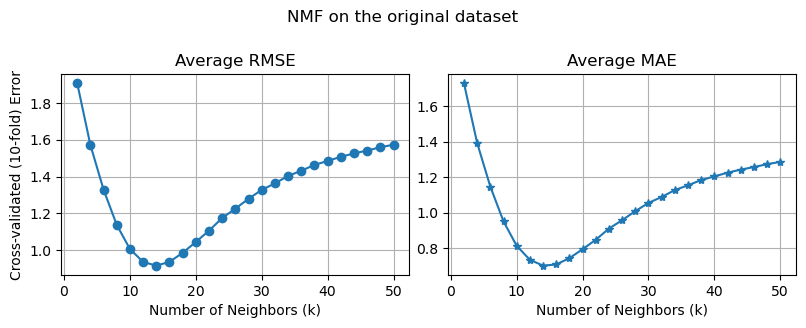

Min average RMSE: 0.916069463395562
Number of latent factors corresponding to the Min average RMSE: 14
Min average MAE: 0.7007809334315901
Number of latent factors corresponding to the Min average MAE: 14


In [29]:
biased = False
find_best_k(biased, data, 'NMF on the original dataset')

The list of genres is shown here:
* Action
* Adventure
* Animation
* Children's
* Comedy
* Crime
* Documentary
* Drama
* Fantasy
* Film-Noir
* Horror
* Musical
* Mystery
* Romance
* Sci-Fi
* Thriller
* War
* Western
* (no genres listed)

This list of genres in the dataset is consisted of 19 items. Optimal number of latern factors is 14 which is not same as the number of generes but it is close.

### Performance on trimmed dataset subsets:  
### Popular subset

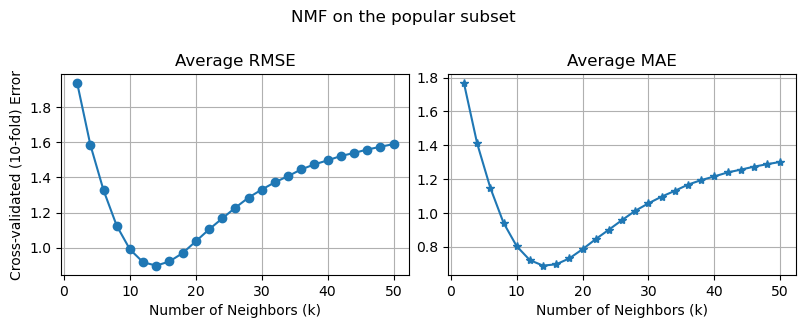

Min average RMSE: 0.8984235025217853
Number of latent factors corresponding to the Min average RMSE: 14
Min average MAE: 0.689022357232881
Number of latent factors corresponding to the Min average MAE: 14


In [30]:
biased = False
find_best_k(biased, pop_data, 'NMF on the popular subset')

### Unpopular subset

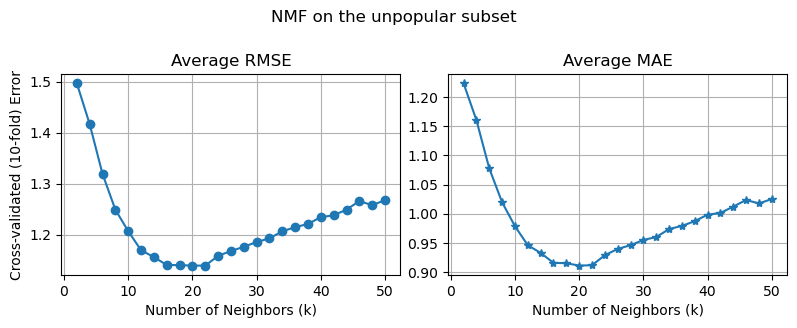

Min average RMSE: 1.1394658865448553
Number of latent factors corresponding to the Min average RMSE: 20
Min average MAE: 0.9115979722229408
Number of latent factors corresponding to the Min average MAE: 20


In [31]:
biased = False
find_best_k(biased, unpop_data, 'NMF on the unpopular subset')

### High variance subset

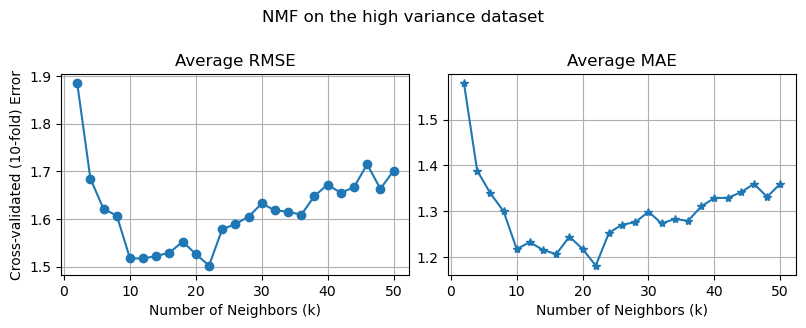

Min average RMSE: 1.5026005147996162
Number of latent factors corresponding to the Min average RMSE: 22
Min average MAE: 1.18146528002896
Number of latent factors corresponding to the Min average MAE: 22


In [32]:
biased = False
find_best_k(biased, hv_data, 'NMF on the high variance dataset')

### Plot the ROC curves 
#### Original dataset

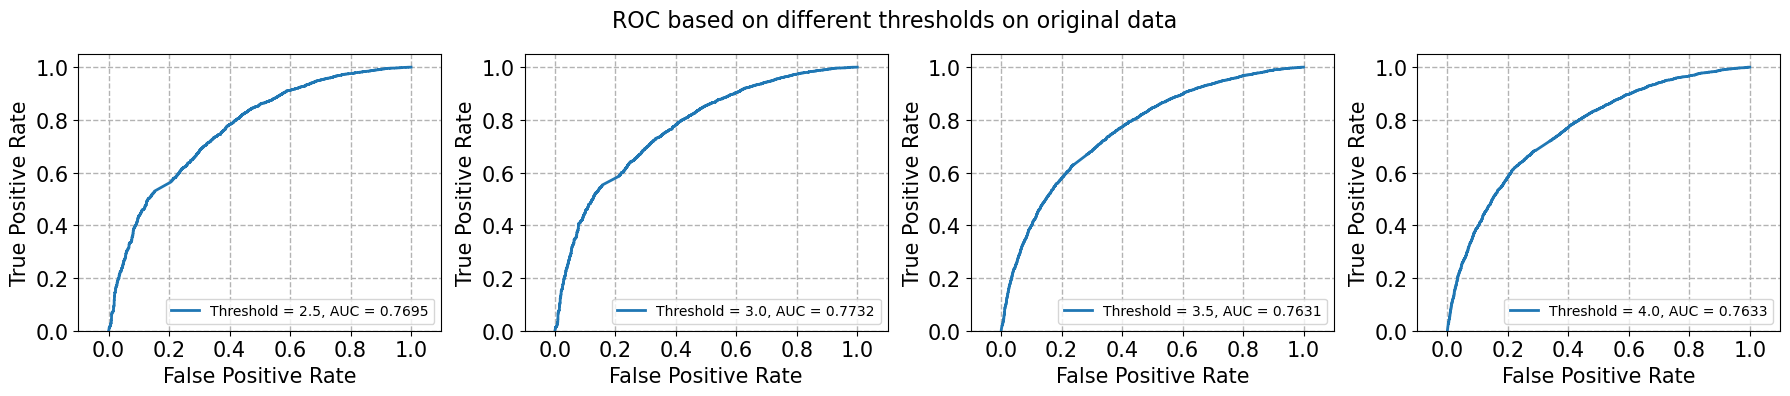

In [33]:
algo = matrix_factorization.NMF(n_factors=14, n_epochs=50)
factorize_plot_ROC(data, algo, 'ROC based on different thresholds on original data')

#### Popular subset

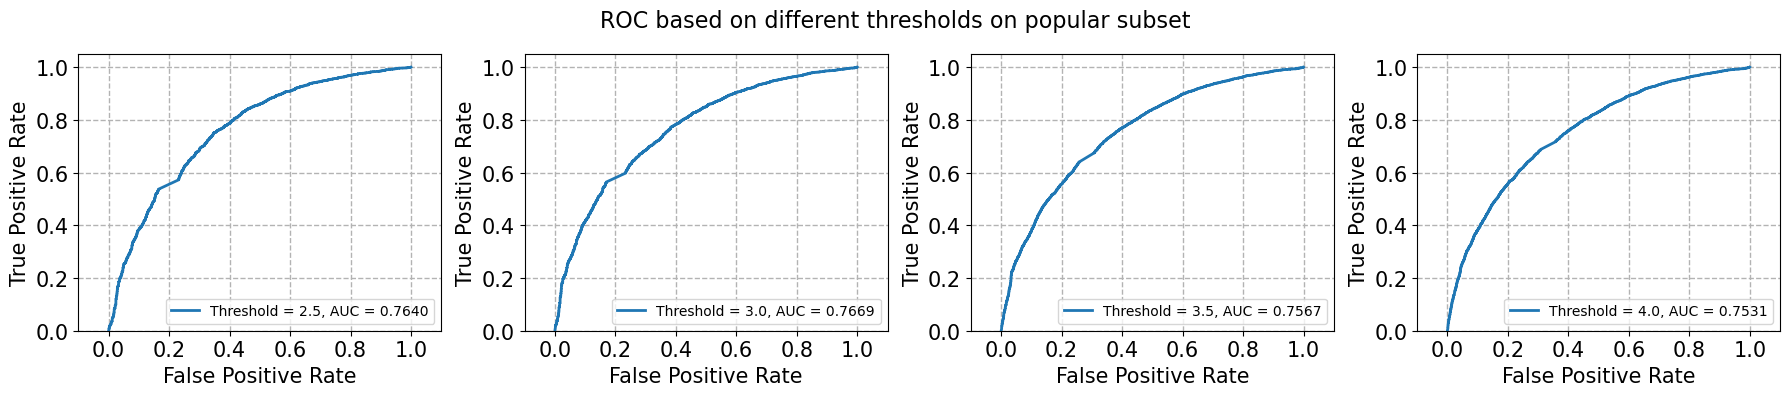

In [34]:
algo = matrix_factorization.NMF(n_factors=14, n_epochs=50)
factorize_plot_ROC(data, algo, 'ROC based on different thresholds on popular subset')

#### Unopular subset

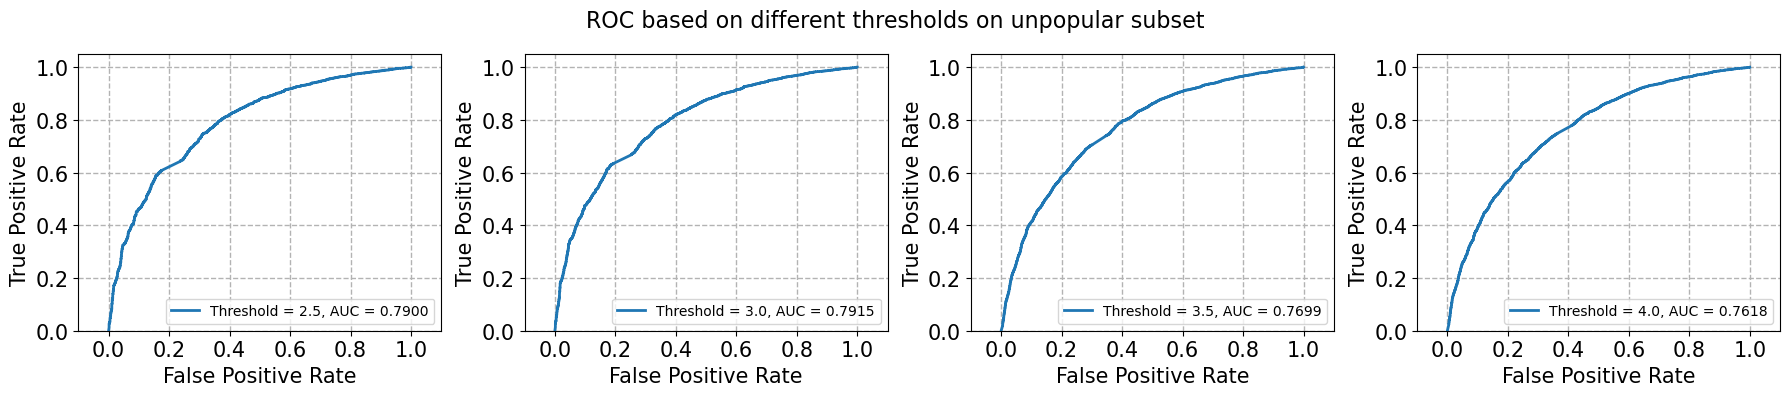

In [63]:
algo = matrix_factorization.NMF(n_factors=20, n_epochs=50)
factorize_plot_ROC(data, algo, 'ROC based on different thresholds on unpopular subset')

#### High variance subset

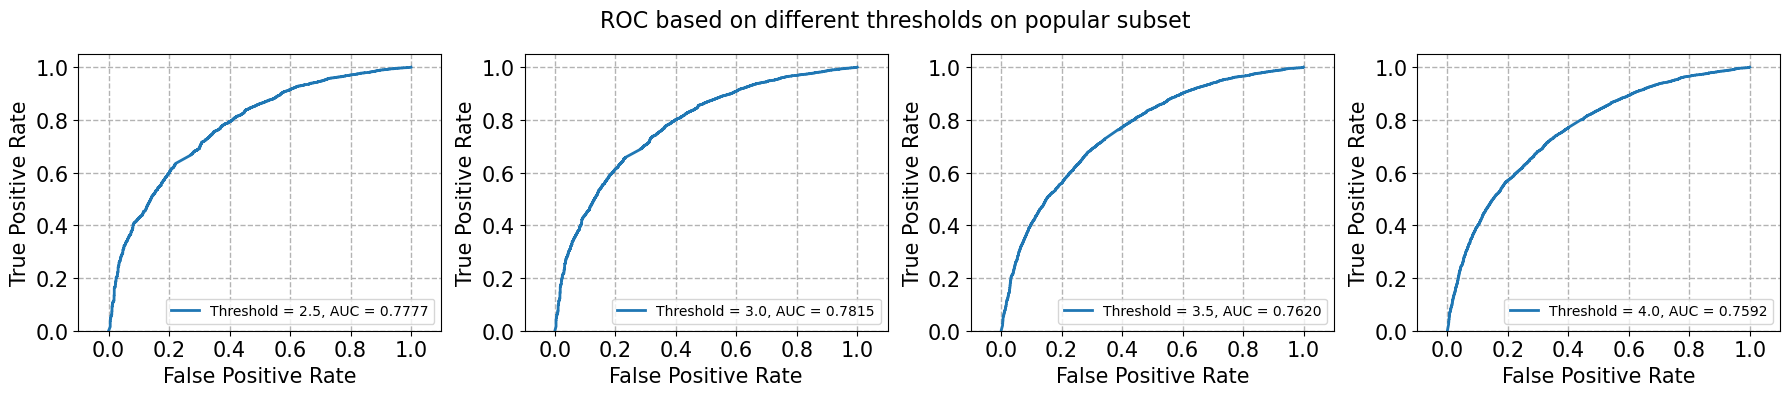

In [64]:
algo = matrix_factorization.NMF(n_factors=22, n_epochs=50)
factorize_plot_ROC(data, algo, 'ROC based on different thresholds on popular subset')

### QUESTION 9: 
- Interpreting the NMF model:

In [37]:
algo = matrix_factorization.NMF(n_factors=20, n_epochs=50, lr_bu=0.005, lr_bi=0.005)

trainset, testset = train_test_split(data, test_size=0.1)

# Train and test algorithm
algo.fit(trainset)
predictions = algo.test(testset)

# item factor
V = algo.qi
print(V.shape)

(9387, 20)


In [38]:
top10_genre = []
cols = [0,5,10, 15, 19]
for col in cols:
    top_10_ind = np.argsort(V[:, col])[::-1][:10]
    
    genre_counts = {}

    # Iterate over the top 10 rows
    for i in range(10):
        # Split genres string on '|'
        genres = movies.iloc[top_10_ind[i]]['genres'].split('|')

        # Count occurrences of each genre
        for genre in genres:
            if genre in genre_counts:
                genre_counts[genre] += 1
            else:
                genre_counts[genre] = 1

    
    top10_genre.append(genre_counts)
    print('-'*20)
    print(f'Genres corresponding to the column number {col+1}:')
    sorted_genre_counts = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)

    # Display sorted genre counts
    print("Sorted genre counts for the first 10 rows:")
    for genre, count in sorted_genre_counts:
        print(f"{genre}: {count}")

--------------------
Genres corresponding to the column number 1:
Sorted genre counts for the first 10 rows:
Action: 3
Adventure: 3
Comedy: 3
Drama: 2
Sci-Fi: 2
Thriller: 2
Documentary: 2
Horror: 2
War: 1
Fantasy: 1
Romance: 1
--------------------
Genres corresponding to the column number 6:
Sorted genre counts for the first 10 rows:
Romance: 5
Comedy: 4
Drama: 3
Sci-Fi: 2
Action: 2
Fantasy: 1
Documentary: 1
Animation: 1
Horror: 1
Thriller: 1
--------------------
Genres corresponding to the column number 11:
Sorted genre counts for the first 10 rows:
Comedy: 5
Drama: 4
Thriller: 4
Romance: 3
Crime: 2
Mystery: 1
Adventure: 1
Fantasy: 1
Horror: 1
Children: 1
Action: 1
--------------------
Genres corresponding to the column number 16:
Sorted genre counts for the first 10 rows:
Drama: 5
Thriller: 3
Comedy: 3
Romance: 3
Musical: 2
Action: 1
War: 1
Horror: 1
Documentary: 1
Adventure: 1
Animation: 1
Children: 1
Fantasy: 1
--------------------
Genres corresponding to the column number 20:
Sort

NMF reduces the dimensionality of the item space by approximating the original item matrix with a lower-dimensional representation (20 here). Each latent factor captures a different aspect of the items, allowing for a more compact representation of the data. Examining the items that have high values on a particular factor can provide insights into the types of items characterized by that factor. For example, 16th and 11th latent factor has high loadings on action-packed and crime-packed movies, respectively, they may be interpreted as representing an "action" and "crime" features.

### QUESTION 10: 
- Designing the MF Collaborative Filter using NMF with bias:


#### Original data

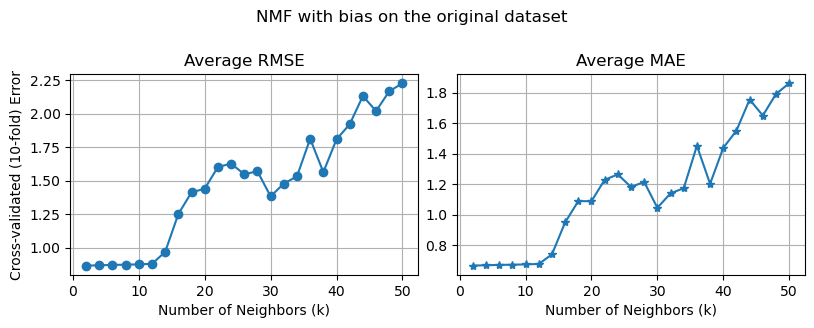

Min average RMSE: 0.868392337851502
Number of latent factors corresponding to the Min average RMSE: 2
Min average MAE: 0.6665932598367675
Number of latent factors corresponding to the Min average MAE: 2


In [39]:
biased = True
find_best_k(biased, data, 'NMF with bias on the original dataset')

####  Popular subset

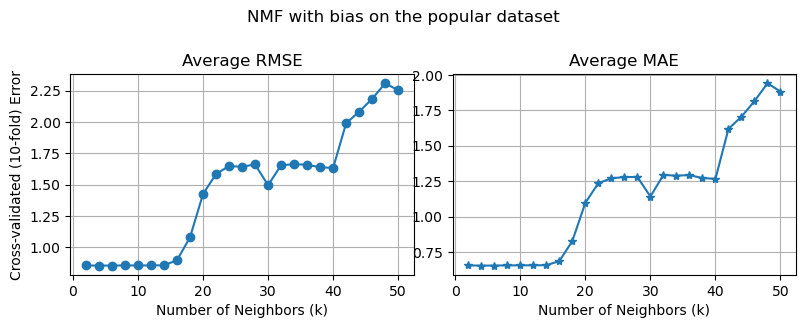

Min average RMSE: 0.8538059392264845
Number of latent factors corresponding to the Min average RMSE: 4
Min average MAE: 0.654472077421249
Number of latent factors corresponding to the Min average MAE: 4


In [40]:
biased = True
find_best_k(biased, pop_data, 'NMF with bias on the popular dataset')

#### Unpopular subset

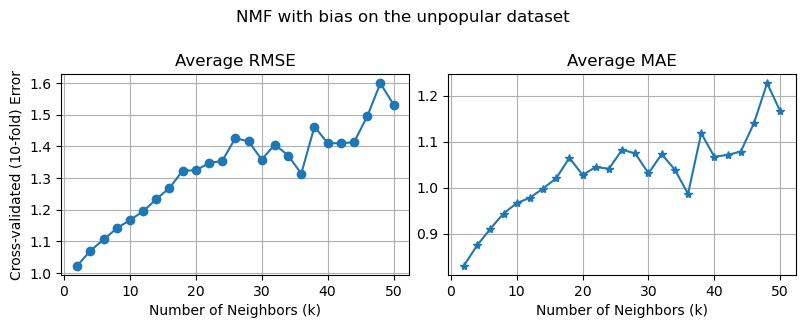

Min average RMSE: 1.0237948019426288
Number of latent factors corresponding to the Min average RMSE: 2
Min average MAE: 0.8309766279559516
Number of latent factors corresponding to the Min average MAE: 2


In [41]:
biased = True
find_best_k(biased, unpop_data, 'NMF with bias on the unpopular dataset')

#### High variance data

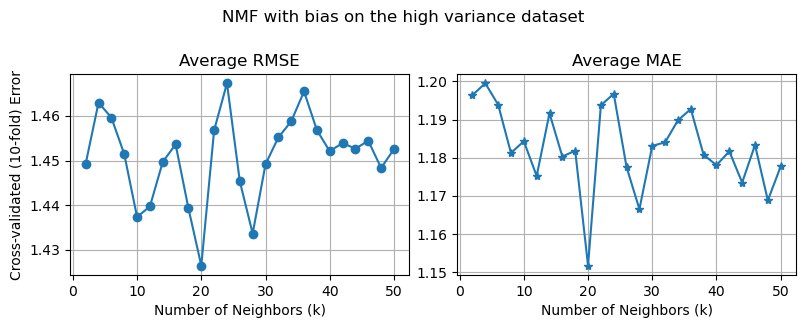

Min average RMSE: 1.426493143264865
Number of latent factors corresponding to the Min average RMSE: 20
Min average MAE: 1.1517123232809874
Number of latent factors corresponding to the Min average MAE: 20


In [42]:
biased = True
find_best_k(biased, hv_data, 'NMF with bias on the high variance dataset')

### Plot the ROC curves 

In [43]:
def factorize_plot_ROC(data, algo, title):
    trainset, testset = train_test_split(data, test_size=0.1)

    # Train and test algorithm
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Get true ratings 
    true_ratings = np.array([pred.r_ui for pred in predictions])

    thresholds = [2.5, 3, 3.5, 4]
    fig, axes = plt.subplots(1, len(thresholds), figsize=(18, 6))
    fig.suptitle(title, fontsize=16)

    for i, t in enumerate(thresholds):
        y_test, y_pred = [], []
        true_labels = (true_ratings >= t).astype(int)

        fpr, tpr, _ = roc_curve(true_labels, [pred.est for pred in predictions])
        roc_auc = auc(fpr, tpr)
        plot_roc(axes[i], fpr, tpr, roc_auc, t)

    plt.tight_layout()
    plt.show()

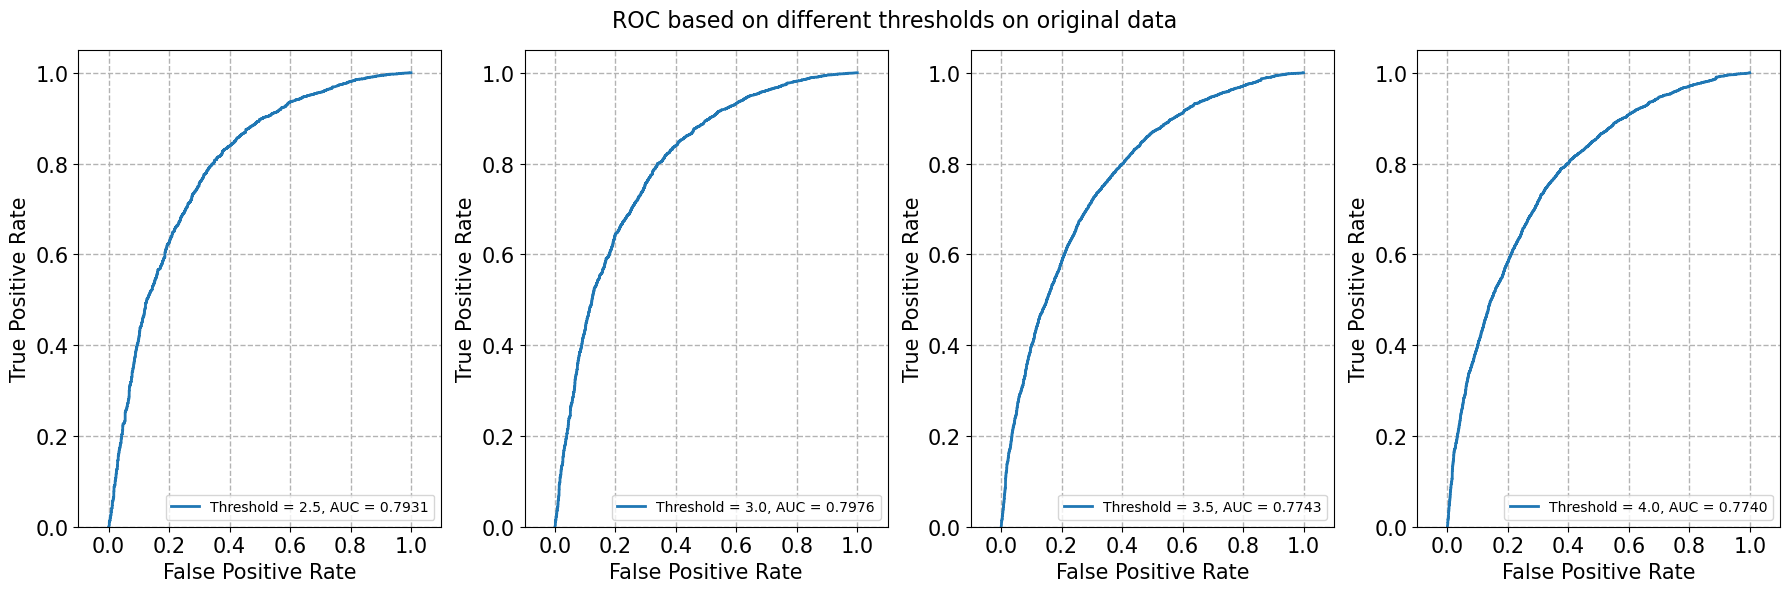

In [44]:
algo = matrix_factorization.NMF(n_factors=2, n_epochs=50, biased=True)
factorize_plot_ROC(data, algo, 'ROC based on different thresholds on original data')

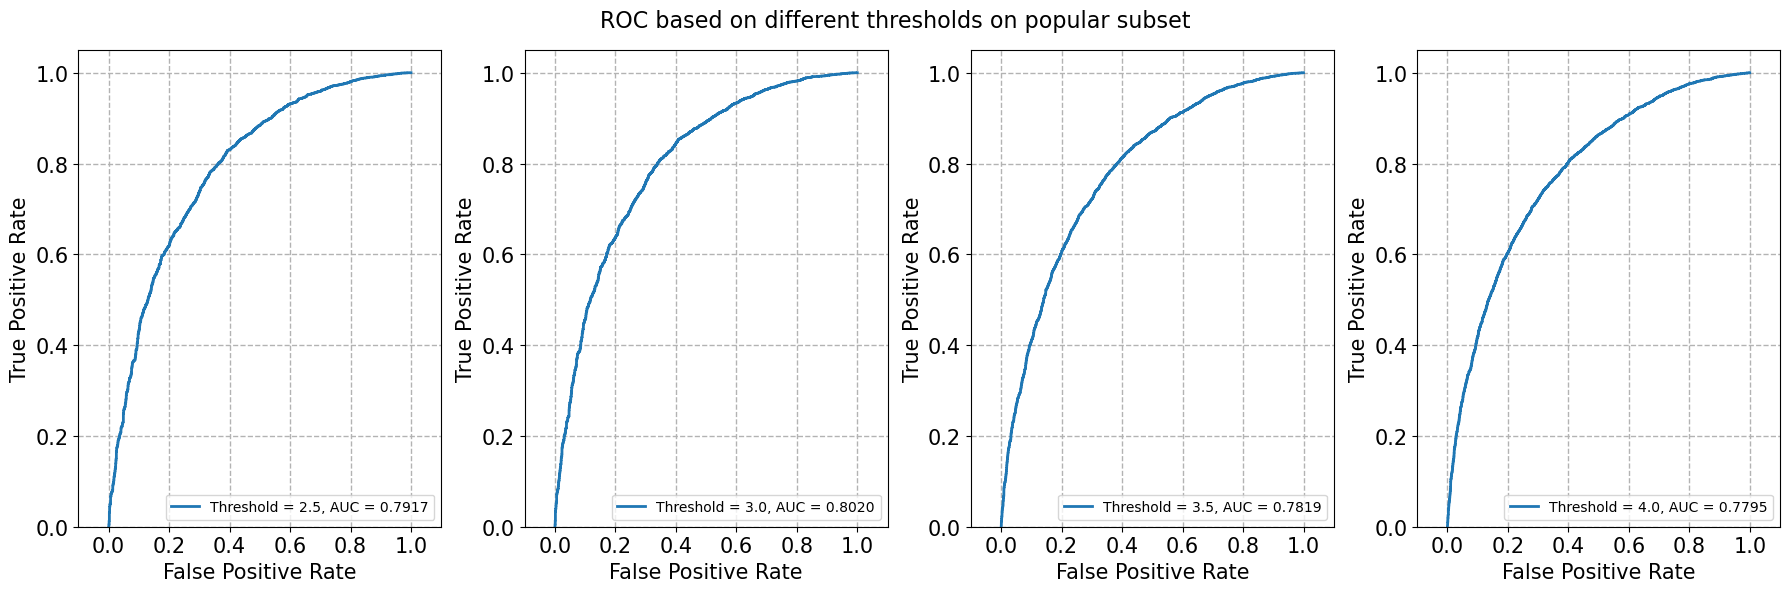

In [45]:
algo = matrix_factorization.NMF(n_factors=4, n_epochs=50, biased=True)
factorize_plot_ROC(pop_data, algo, 'ROC based on different thresholds on popular subset')

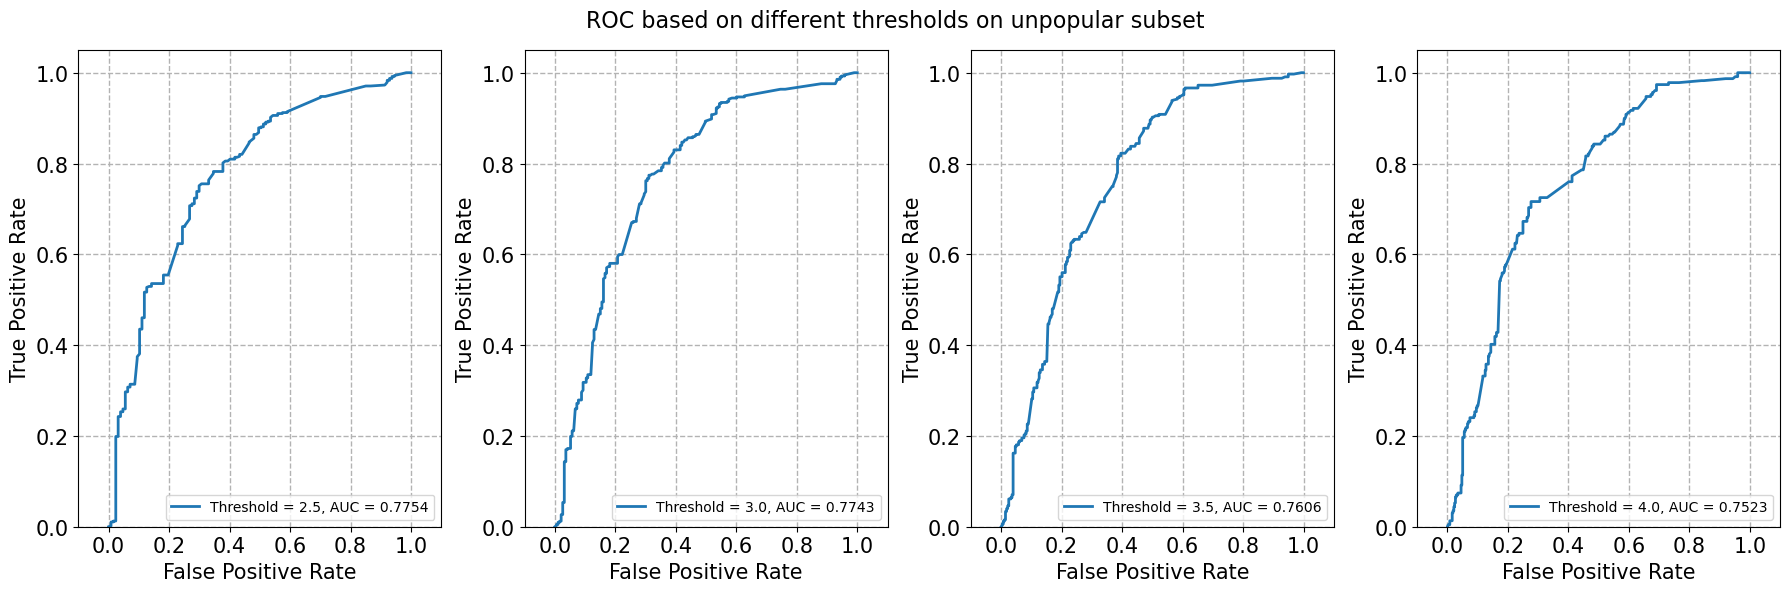

In [46]:
algo = matrix_factorization.NMF(n_factors=2, n_epochs=50, biased=True)
factorize_plot_ROC(unpop_data, algo, 'ROC based on different thresholds on unpopular subset')

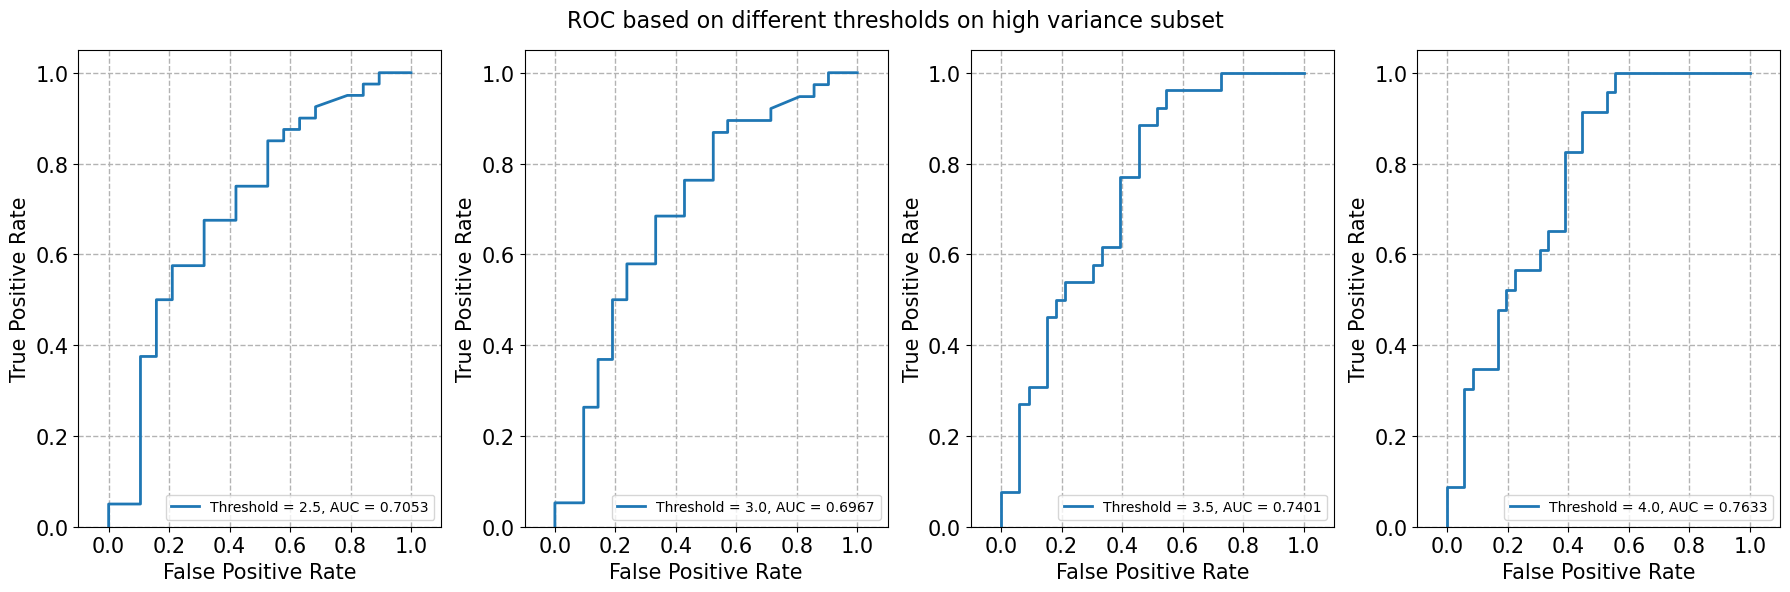

In [47]:
algo = matrix_factorization.NMF(n_factors=20, n_epochs=50, biased=True)
factorize_plot_ROC(hv_data, algo, 'ROC based on different thresholds on high variance subset')

## Naive collaborative filtering
### QUESTION 11: 
- Designing a Na ̈ıve Collaborative Filter:


In [48]:
from surprise.prediction_algorithms import AlgoBase

class NaiveCollaborativeFilter(AlgoBase):
    def fit(self, trainset):
        AlgoBase.fit(self, trainset)
        # Calculate mean rating for each user
        self.user_means = {}
        for user_id in self.trainset.all_users():
            ratings = [rating for (_, rating) in self.trainset.ur[user_id]]
            self.user_means[user_id] = sum(ratings) / len(ratings)
        return self

    def estimate(self, u, i):
        # Predict the mean rating of the user for the item
        if u in self.user_means:
            return self.user_means[u]
        else:
            return self.trainset.global_mean

algo = NaiveCollaborativeFilter()

# 10-fold cross-validation
cv_results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10, verbose=False)

# Compute the average RMSE across all 10 folds
average_rmse = cv_results['test_rmse'].mean()
print("Average RMSE:", average_rmse)

# Compute the average MAE across all 10 folds
average_mae = cv_results['test_mae'].mean()
print("Average MAE:", average_mae)


Average RMSE: 0.9412024216287872
Average MAE: 0.73382007967509


####  Popular subset

In [49]:
# 10-fold cross-validation
cv_results = cross_validate(algo, pop_data, measures=['RMSE', 'MAE'], cv=10, verbose=False)

# Compute the average RMSE across all 10 folds
average_rmse = cv_results['test_rmse'].mean()
print("Average RMSE:", average_rmse)

# Compute the average MAE across all 10 folds
average_mae = cv_results['test_mae'].mean()
print("Average MAE:", average_mae)

Average RMSE: 0.937472915981558
Average MAE: 0.7302889226404347


#### Unpopular subset

In [50]:
# 10-fold cross-validation
cv_results = cross_validate(algo, unpop_data, measures=['RMSE', 'MAE'], cv=10, verbose=False)

# Compute the average RMSE across all 10 folds
average_rmse = cv_results['test_rmse'].mean()
print("Average RMSE:", average_rmse)

# Compute the average MAE across all 10 folds
average_mae = cv_results['test_mae'].mean()
print("Average MAE:", average_mae)

Average RMSE: 0.9045106562125736
Average MAE: 0.6919719649515814


#### High variance data

In [51]:
# 10-fold cross-validation
cv_results = cross_validate(algo, hv_data, measures=['RMSE', 'MAE'], cv=10, verbose=False)

# Compute the average RMSE across all 10 folds
average_rmse = cv_results['test_rmse'].mean()
print("Average RMSE:", average_rmse)

# Compute the average MAE across all 10 folds
average_mae = cv_results['test_mae'].mean()
print("Average MAE:", average_mae)

Average RMSE: 1.4188763365357515
Average MAE: 1.105338345651309


### QUESTION 12:
- Comparing the most performant models across architecture:

Computing the msd similarity matrix...
Done computing similarity matrix.


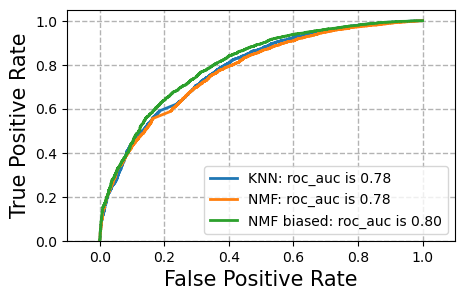

In [52]:
algo_knn = knns.KNNWithMeans(k=20, min_k=1)
algo_NMF = matrix_factorization.NMF(n_factors=14, n_epochs=50)
algo_NMF_bias = matrix_factorization.NMF(n_factors=2, n_epochs=50, biased=True)
algos = [algo_knn, algo_NMF, algo_NMF_bias]
trainset, testset = train_test_split(data, test_size=0.1)

plt.figure(figsize=(5, 3))
algo_name = ['KNN', 'NMF', 'NMF biased']
for algo, label in zip(algos, algo_name):
    
    # Train and test algorithm
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Get true ratings 
    true_ratings = np.array([pred.r_ui for pred in predictions])

    threshold = 3

    y_test, y_pred = [], []
    true_labels = (true_ratings >= threshold).astype(int)

    fpr, tpr, _ = roc_curve(true_labels, [pred.est for pred in predictions])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label= label+ f': roc_auc is {roc_auc:.2f}')


# Customize plot appearance
plt.grid(color='0.7', linestyle='--', linewidth=1)
plt.xlim([-0.1, 1.1])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.legend(loc="lower right")        
plt.show()

Each model is trained based on the best hyperparameter obtained in the previous sections. As shown in the above plot, NMF with bias term has the best performance on the original dataset.

## Ranking
### QUESTION 13: 
- Data Understanding and Preprocessing:
    - Print out the number of unique queries in total and show distribution of relevance labels.

In [53]:
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import ndcg_score
import numpy as np

# Load the dataset for one fold
def load_one_fole(data_path):
    X_train, y_train, qid_train = load_svmlight_file(str(data_path + 'train.txt'), query_id=True)
    X_val, y_val, qid_val = load_svmlight_file(str(data_path + 'vali.txt'), query_id=True)
    X_test, y_test, qid_test = load_svmlight_file(str(data_path + 'test.txt'), query_id=True)

    y_train = y_train.astype(int)
    y_val = y_val.astype(int)
    y_test = y_test.astype(int)
    _, group_train = np.unique(qid_train, return_counts=True)
    _, group_val = np.unique(qid_val, return_counts=True)
    _, group_test = np.unique(qid_test, return_counts=True)
    return X_train, y_train, qid_train, group_train, X_val, y_val, qid_val, group_val, X_test, y_test, qid_test, group_test

def ndcg_single_query(y_score, y_true, k):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

# calculate NDCG score given a trained model 
def compute_ndcg_all(model, X_test, y_test, qids_test, k=10):
    unique_qids = np.unique(qids_test)
    ndcg_ = list()
    for i, qid in enumerate(unique_qids):
        y = y_test[qids_test == qid]

        if np.sum(y) == 0:
            continue

        p = model.predict(X_test[qids_test == qid])

        idcg = ndcg_single_query(y, y, k=k)
        ndcg_.append(ndcg_single_query(p, y, k=k) / idcg)
    return np.mean(ndcg_)

# get importance of features
def get_feature_importance(model, importance_type='gain'):
    return model.booster_.feature_importance(importance_type=importance_type)

In [54]:
i = 1
path = 'MSLR-WEB10K/Fold' + str(i) + '/'
X_train, y_train, qid_train, group_train,\
X_val, y_val, qid_val, group_val, X_test,\
y_test, qid_test, group_test = load_one_fole(path)
    
all_queries = np.concatenate((group_train, group_test, group_val)) 
all_labels = np.concatenate((y_train, y_test, y_val)) 
print('number of unique queries in total:', len(all_queries))    

number of unique queries in total: 10000


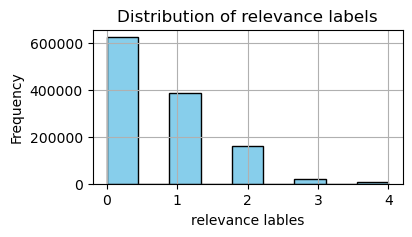

In [55]:
plt.figure(figsize=(4, 2))
plt.hist(all_labels, bins=9, color='skyblue', edgecolor='black')
plt.title('Distribution of relevance labels')
plt.xlabel('relevance lables')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
